In [21]:
import pandas as pd
import folium
import json
import requests
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('seasonal_summary_final_fahrenheit.csv') #input data
df_wind = pd.read_csv('seasonal_summary_wind_full.csv')

In [9]:
# climate scores for each county -- Now includes w/ WIND)
def calculate_county_scores(df, df_wind):
    scores = []
    df = df[df['county_name'] != 'Sutter']
    
    for county in df['county_name'].unique():
        county_data = df[df['county_name'] == county]
        
        # temp comfort score
        avg_temp = county_data['TAVG'].mean()
        if 60 <= avg_temp <= 70:
            temp_comfort_score = 100
        elif avg_temp < 60:
            temp_comfort_score = max(0, 100 - (60 - avg_temp) * 4)
        else:
            temp_comfort_score = max(0, 100 - (avg_temp - 70) * 4)
        
        # temp stability score
        temp_range = county_data['TAVG'].max() - county_data['TAVG'].min()
        if temp_range <= 15:
            temp_stability_score = 100
        else:
            temp_stability_score = max(0, 100 - (temp_range - 15) * 4)
        
        # prcp score
        avg_precip = county_data['PRCP'].mean()
        if 38 <= avg_precip <= 102:
            precip_score = 100
        elif avg_precip < 38:
            precip_score = max(0, (avg_precip / 38) * 100 - 20)
        else:
            precip_score = max(0, 100 - (avg_precip - 102) * 0.6)
    

# summer comfort 
        summer_data = county_data[county_data['season'] == 'Summer']
        if not summer_data.empty:
            summer_max = summer_data['TMAX'].values[0]
            if summer_max <= 80:
                summer_comfort_score = 100
            elif summer_max <= 90:
                summer_comfort_score = max(0, 100 - (summer_max - 80) * 4)
            elif summer_max <= 100:
                summer_comfort_score = max(0, 60 - (summer_max - 90) * 5)
            else:
                summer_comfort_score = max(0, 10 - (summer_max - 100) * 2)
        else:
            summer_comfort_score = 50
        
        # winter comfort 
        winter_data = county_data[county_data['season'] == 'Winter']
        if not winter_data.empty:
            winter_min = winter_data['TMIN'].values[0]
            if winter_min >= 40:
                winter_comfort_score = 100
            elif winter_min >= 30:
                winter_comfort_score = max(0, 100 - (40 - winter_min) * 3)
            else:
                winter_comfort_score = max(0, 70 - (30 - winter_min) * 5)
        else:
            winter_comfort_score = 50
        
        # extreme scoring
        max_temp_overall = county_data['TMAX'].max()
        min_temp_overall = county_data['TMIN'].min()
        extreme_penalty = 0
        
        if max_temp_overall > 95:
            extreme_penalty += (max_temp_overall - 95) * 2
        if min_temp_overall < 30:
            extreme_penalty += (30 - min_temp_overall) * 2
        extreme_score = max(0, 100 - extreme_penalty)
        
# wind comfort score
        # all in mph
        wind_data = df_wind[df_wind['county_name'] == county]
        if not wind_data.empty:
            avg_wind = wind_data['wind_mean'].mean()
            # optimal range: 7 - 10 mph (breeze)
            if 7 <= avg_wind <= 10:
                wind_score = 100
            elif avg_wind < 7:
                # penalty for too calm 
                wind_score = max(0, 100 - (7 - avg_wind) * 10)
            else:
                # penalty for too windy
                wind_score = max(0, 100 - (avg_wind - 10) * 8)
        else:
            wind_score = 50  # Default if no wind data
        
        # total climate score : adjusted 
        climate_score = (
            temp_comfort_score * 0.18 +      # all reduced now with wind as a parameter 
            temp_stability_score * 0.13 +    
            precip_score * 0.14 +            
            summer_comfort_score * 0.28 +    
            winter_comfort_score * 0.09 +    
            extreme_score * 0.09 +           
            wind_score * 0.09                # new 9% weight
        )
        
        scores.append({
            'county_name': county,
            'climate_score': round(climate_score, 1)
        })
    
    return pd.DataFrame(scores)


scores_df = calculate_county_scores(df, df_wind) # total scores


In [11]:


#California centered map
m = folium.Map(location=[37.0, -119.5], zoom_start=6)

# CA counties GeoJSON
url = 'https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json'
response = requests.get(url)
geojson_data = response.json()

# filter for all CA counties (FIPS start with 06
ca_counties = {
    "type": "FeatureCollection",
    "features": [f for f in geojson_data['features'] if f['id'].startswith('06')]
}

fips_to_data = {} # dictionary maps FIPS to county data
for _, row in scores_df.iterrows():
    county_name = row['county_name']
    score = row['climate_score']
    
    # FIPS from original data
    county_fips = df[df['county_name'] == county_name]['county_fips'].iloc[0]
    fips_code = county_fips.replace('FIPS:', '')
    fips_to_data[fips_code] = {'name': county_name, 'score': score}

# A function for color based on score
def get_color(score):
    if score >= 95:
        return '#1a9641'  # *** Darker green
    elif score >= 90:
        return '#a6d96a'  # Lightish green
    elif score >= 80:
        return '#ffffbf'  # -- Yellow
    elif score >= 70:
        return '#fdae61'  # -- Orange
    elif score >= 60:
        return '#f46d43'  # -- Dark orange
    else:
        return '#d73027'  # Red

In [15]:
# each CA county as a separate GeoJson layer with tooltip
for feature in ca_counties['features']:
    fips = feature['id']
    if fips in fips_to_data:
        county_name = fips_to_data[fips]['name']
        score = fips_to_data[fips]['score']
        color = get_color(score)
        
        folium.GeoJson(
            feature,
            style_function=lambda x, color=color: {
                'fillColor': color,
                'color': 'black',
                'weight': 1,
                'fillOpacity': 0.7
            },
            tooltip=f"{county_name}: {score}"
        ).add_to(m)


m.save('california_climate_map_with_wind.html')
print("Map saved") # save 

Map saved as 'california_climate_map.html'


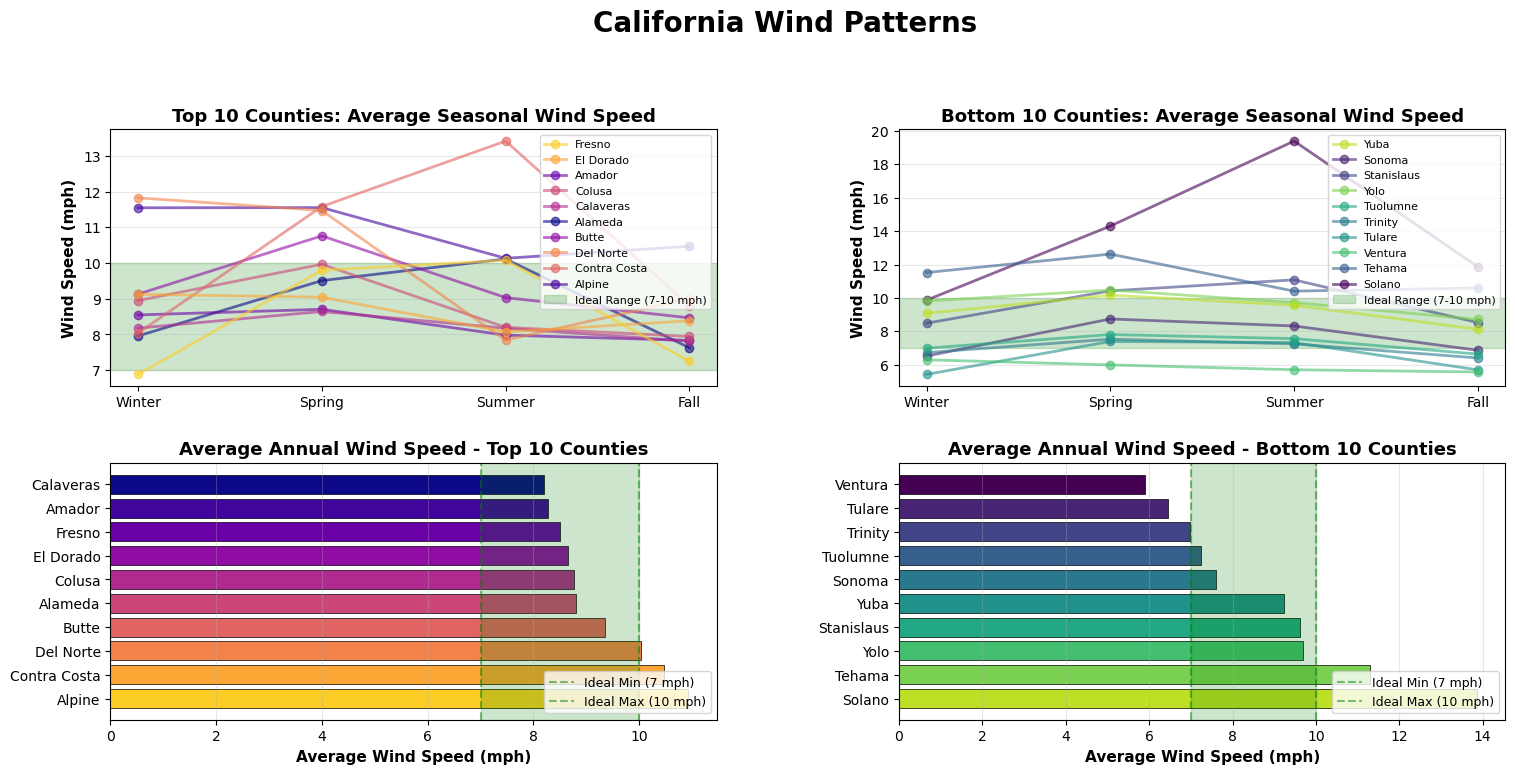

In [25]:

# top 10 county names
top10_counties = scores_df.head(10)['county_name'].tolist()
bottom10_counties = scores_df.tail(10)['county_name'].tolist()

# top 10 wind data
top10_data = df_wind[df_wind['county_name'].isin(top10_counties)]
bottom10_data = df_wind[df_wind['county_name'].isin(bottom10_counties)]


fig = plt.figure(figsize=(18, 12)) # for multiple subplots
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# a title
fig.suptitle('California Wind Patterns', fontsize=20, fontweight='bold', y=0.98)

# order of seasons
season_order = ['Winter', 'Spring', 'Summer', 'Fall']



# ------- seasonal Wind of top 10 counties 

ax1 = fig.add_subplot(gs[0, 0])
cmap_top = plt.colormaps.get_cmap('plasma')
colors_top10 = [cmap_top(i/len(top10_counties)) for i in range(len(top10_counties))]

for idx, county in enumerate(top10_counties):
    county_data = top10_data[top10_data['county_name'] == county]
    county_data = county_data.set_index('season').reindex(season_order)
    ax1.plot(season_order, county_data['wind_mean'], marker='o', linewidth=2.0, label=county, alpha=0.6, color=colors_top10[idx])

ax1.set_ylabel('Wind Speed (mph)', fontweight='bold', fontsize=11)
ax1.set_title('Top 10 Counties: Average Seasonal Wind Speed', fontweight='bold', fontsize=13)
ax1.legend(fontsize=8, loc='upper right')
ax1.grid(axis='y', alpha=0.3)

# the ideal wind range shading (in green)
ax1.axhspan(7, 10, alpha=0.2, color='green', label='Ideal Range (7-10 mph)')
ax1.legend(fontsize=8, loc='upper right')

handles, labels = ax1.get_legend_handles_labels()

# grab avg wind values (sorting)
avg_wind_values = []
for county in top10_counties:
    county_data = top10_data[top10_data['county_name'] == county]
    avg_wind_values.append(county_data['wind_mean'].mean())

# sort handles and labels by average wind. lowest #1 
sorted_pairs = sorted(zip(handles[:-1], labels[:-1], avg_wind_values), key=lambda x: abs(x[2] - 8.5))  # Sort by distance from ideal midpoint (8.5)
handles_sorted = [p[0] for p in sorted_pairs] + [handles[-1]]  # add back the ideal range
labels_sorted = [p[1] for p in sorted_pairs] + [labels[-1]]
ax1.legend(handles_sorted, labels_sorted, fontsize=8, loc='upper right')



# ------- seasonal Wind of bottom 10 counties

ax2 = fig.add_subplot(gs[0, 1])
cmap_bottom = plt.colormaps.get_cmap('viridis')
colors_bottom10 = [cmap_bottom(i/len(bottom10_counties)) for i in range(len(bottom10_counties))]

for idx, county in enumerate(bottom10_counties):
    county_data = bottom10_data[bottom10_data['county_name'] == county]
    county_data = county_data.set_index('season').reindex(season_order)
    ax2.plot(season_order, county_data['wind_mean'], marker='o', linewidth=2.0, label=county, alpha=0.6, color=colors_bottom10[idx])

ax2.set_ylabel('Wind Speed (mph)', fontweight='bold', fontsize=11)
ax2.set_title('Bottom 10 Counties: Average Seasonal Wind Speed', fontweight='bold', fontsize=13)
ax2.legend(fontsize=8, loc='upper right')
ax2.grid(axis='y', alpha=0.3)

# ideal wind range shading in green
ax2.axhspan(7, 10, alpha=0.2, color='green', label='Ideal Range (7-10 mph)')

handles, labels = ax2.get_legend_handles_labels()
# avg wind values for sortinggg
avg_wind_values = []
for county in bottom10_counties:
    county_data = bottom10_data[bottom10_data['county_name'] == county]
    avg_wind_values.append(county_data['wind_mean'].mean())

# sort handles and labels
sorted_pairs = sorted(zip(handles[:-1], labels[:-1], avg_wind_values), key=lambda x: abs(x[2] - 8.5))
handles_sorted = [p[0] for p in sorted_pairs] + [handles[-1]]
labels_sorted = [p[1] for p in sorted_pairs] + [labels[-1]]
ax2.legend(handles_sorted, labels_sorted, fontsize=8, loc='upper right')



# ------- annual avg wind speed for top 10 

ax3 = fig.add_subplot(gs[1, 0])
# avg wind across all four seasons
top10_avg_wind = top10_data.groupby('county_name')['wind_mean'].mean().sort_values(ascending=True)

# plasma color
cmap_top10 = plt.colormaps.get_cmap('plasma')
colors_top = [cmap_top10(i/len(top10_avg_wind)) for i in range(len(top10_avg_wind))]

ax3.barh(range(len(top10_avg_wind)), top10_avg_wind.to_numpy(), color=colors_top, edgecolor='black', linewidth=0.5)
ax3.set_yticks(range(len(top10_avg_wind)))
ax3.set_yticklabels(top10_avg_wind.index.to_list(), fontsize=10)
ax3.set_xlabel('Average Wind Speed (mph)', fontweight='bold', fontsize=11)
ax3.set_title('Average Annual Wind Speed - Top 10 Counties', fontweight='bold', fontsize=13)
ax3.invert_yaxis()
ax3.grid(axis='x', alpha=0.3)

# ideal range +  labels
ax3.axvline(x=7, color='green', linestyle='--', linewidth=1.5, alpha=0.5, label='Ideal Min (7 mph)')
ax3.axvline(x=10, color='green', linestyle='--', linewidth=1.5, alpha=0.5, label='Ideal Max (10 mph)')
ax3.axvspan(7, 10, alpha=0.2, color='green')
ax3.legend(fontsize=9, loc='lower right')




# ------- annual avg wind speed for bottom 10 
ax4 = fig.add_subplot(gs[1, 1])

# avg wind across four seasons
bottom10_avg_wind = bottom10_data.groupby('county_name')['wind_mean'].mean().sort_values(ascending=True)

# viridis colors
cmap_bottom10 = plt.colormaps.get_cmap('viridis')
colors_bottom = [cmap_bottom10(i/len(bottom10_avg_wind)) for i in range(len(bottom10_avg_wind))]

ax4.barh(range(len(bottom10_avg_wind)), bottom10_avg_wind.to_numpy(), color=colors_bottom, edgecolor='black', linewidth=0.5)
ax4.set_yticks(range(len(bottom10_avg_wind)))
ax4.set_yticklabels(bottom10_avg_wind.index.to_list(), fontsize=10)
ax4.set_xlabel('Average Wind Speed (mph)', fontweight='bold', fontsize=11)
ax4.set_title('Average Annual Wind Speed - Bottom 10 Counties', fontweight='bold', fontsize=13)
ax4.invert_yaxis()
ax4.grid(axis='x', alpha=0.3)

# optimal ranges
ax4.axvline(x=7, color='green', linestyle='--', linewidth=1.5, alpha=0.5, label='Ideal Min (7 mph)')
ax4.axvline(x=10, color='green', linestyle='--', linewidth=1.5, alpha=0.5, label='Ideal Max (10 mph)')
ax4.axvspan(7, 10, alpha=0.2, color='green')
ax4.legend(fontsize=9, loc='lower right')

plt.show()